<a href="https://colab.research.google.com/github/soumik12345/examples/blob/master/colabs/jax/training_with_tfrecords_in_jax_imagenette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q wandb flax

In [2]:
import os
import wandb
import numpy as np
from glob import glob
from typing import Callable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import optax

from flax import linen as nn
from flax.training import train_state
from flax.serialization import (
    to_state_dict, msgpack_serialize, from_bytes
)

import tensorflow as tf
import tensorflow_datasets as tfds
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
wandb.init(
    project="simple-training-loop",
    entity="jax-series",
    job_type="tfrecord"
)

config = wandb.config
config.seed = 42
config.image_size = 227
config.batch_size = 64
config.pooling = "max"
config.learning_rate = 1e-4
config.epochs = 15
config.artifact_address = 'jax-series/simple-training-loop/imagenette-tfrecords:v3'
config.labels = [
    'tench', 'english_springer', 'english_springer', 'chain_saw',
    'church', 'french_horn', 'grabage_truck', 'gas_pump',
    'golf_ball', 'parachute'
]

MODULE_DICT = {
    "avg": nn.avg_pool,
    "max": nn.max_pool,
}

wandb: Currently logged in as: geekyrakshit (jax-series). Use `wandb login --relogin` to force relogin


In [4]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def read_labeled_tfrecord(example):
    feature = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }

    example = tf.io.parse_single_example(example, feature)
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int32)
    return image, label

def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(
        filenames, num_parallel_reads=AUTOTUNE
    )
    dataset_len = sum(1 for _ in dataset)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(
        read_labeled_tfrecord, num_parallel_calls=AUTOTUNE
    ) 
    return dataset, dataset_len

In [5]:
artifact = wandb.use_artifact(
    config.artifact_address, type='dataset'
)
artifact_dir = artifact.download()
train_files = glob(os.path.join(artifact_dir, "train", "*.tfrec"))
val_files = glob(os.path.join(artifact_dir, "val", "*.tfrec"))

wandb: Downloading large artifact imagenette-tfrecords:v3, 333.30MB. 27 files... Done. 0:0:0.1


In [6]:
sample_dataset, _ = load_dataset(train_files)
sample_dataset = sample_dataset.shuffle(1024)
sample_dataset.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

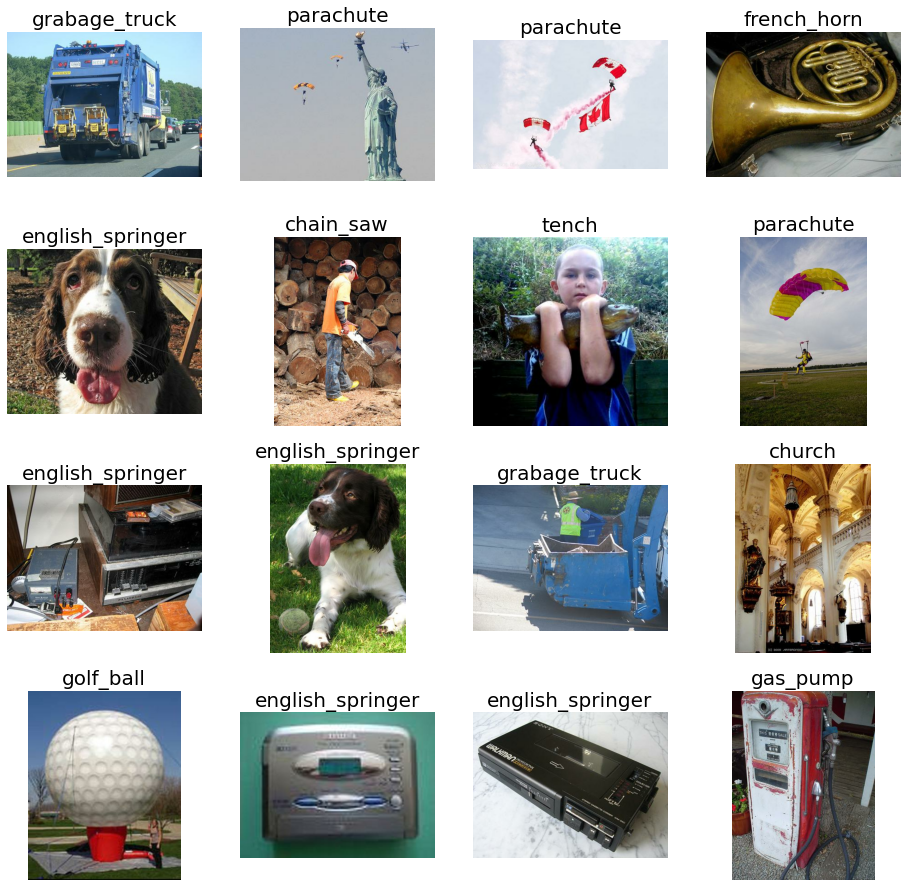

In [7]:
plt.figure(figsize=(16, 16))
for i in range(16):
    x, y = next(iter(sample_dataset))
    x, y = x.numpy(), y.numpy().tolist()
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(x)
    plt.axis("off")
    name = config.labels[y]
    ax.set_title(name, fontsize=20)

In [8]:
def resize_image(image, label):
    image = tf.image.resize(
        image, [config.image_size, config.image_size]
    )
    return image, label


def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return image, label

def get_training_dataset(filenames, batch_size):
    dataset, dataset_len = load_dataset(filenames, ordered = False)
    dataset = dataset.map(
        resize_image, num_parallel_calls=AUTOTUNE
    )
    dataset = dataset.map(
        data_augment, num_parallel_calls=AUTOTUNE
    )
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset, dataset_len // batch_size

def get_val_dataset(filenames, batch_size):
    dataset, dataset_len = load_dataset(filenames, ordered = True)
    dataset = dataset.map(
        resize_image, num_parallel_calls=AUTOTUNE
    )
    dataset = dataset.map(
        data_augment, num_parallel_calls=AUTOTUNE
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset, dataset_len // batch_size

In [9]:
train_dataset, num_train_batches = get_training_dataset(train_files, config.batch_size)
val_dataset, num_val_batches = get_training_dataset(val_files, config.batch_size)

In [10]:
class AlexNet(nn.Module):
    num_classes: int
    pool_module: Callable = nn.avg_pool

    def setup(self):
        self.conv_1 = nn.Conv(
            features=96, kernel_size=(11, 11), strides=4, padding="VALID"
        )
        self.conv_2 = nn.Conv(
            features=256, kernel_size=(5, 5), strides=1, padding="VALID"
        )
        self.conv_3 = nn.Conv(
            features=384, kernel_size=(3, 3), strides=1, padding="VALID"
        )
        self.conv_4 = nn.Conv(
            features=384, kernel_size=(3, 3), strides=1, padding="VALID"
        )
        self.conv_5 = nn.Conv(
            features=256, kernel_size=(3, 3), strides=1, padding="VALID"
        )
        self.dense_1 = nn.Dense(features=1024)
        self.dense_2 = nn.Dense(features=512)
        self.dense_output = nn.Dense(features=self.num_classes)
    
    def __call__(self, x):
        x = nn.relu(self.conv_1(x))
        x = self.pool_module(x, window_shape=(3, 3), strides=(2, 2))
        x = nn.relu(self.conv_2(x))
        x = self.pool_module(x, window_shape=(3, 3), strides=(2, 2))
        x = nn.relu(self.conv_3(x))
        x = nn.relu(self.conv_4(x))
        x = nn.relu(self.conv_5(x))
        x = self.pool_module(x, window_shape=(3, 3), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.relu(self.dense_1(x))
        x = nn.relu(self.dense_2(x))
        return self.dense_output(x)

In [11]:
rng = jax.random.PRNGKey(config.seed)
x = jnp.ones(
    shape=(config.batch_size, config.image_size, config.image_size, 3)
)
model = AlexNet(
    num_classes=len(config.labels),
    pool_module=MODULE_DICT[config.pooling]
)
params = model.init(rng, x)
jax.tree_map(lambda x: x.shape, params)

FrozenDict({
    params: {
        conv_1: {
            bias: (96,),
            kernel: (11, 11, 3, 96),
        },
        conv_2: {
            bias: (256,),
            kernel: (5, 5, 96, 256),
        },
        conv_3: {
            bias: (384,),
            kernel: (3, 3, 256, 384),
        },
        conv_4: {
            bias: (384,),
            kernel: (3, 3, 384, 384),
        },
        conv_5: {
            bias: (256,),
            kernel: (3, 3, 384, 256),
        },
        dense_1: {
            bias: (1024,),
            kernel: (1024, 1024),
        },
        dense_2: {
            bias: (512,),
            kernel: (1024, 512),
        },
        dense_output: {
            bias: (10,),
            kernel: (512, 10),
        },
    },
})

In [12]:
nn.tabulate(model, rng)(x)

                            AlexNet Summary                            
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path         ┃ outputs               ┃ params                       ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs       │ float32[64,227,227,3] │                              │
├──────────────┼───────────────────────┼──────────────────────────────┤
│ conv_1       │ float32[64,55,55,96]  │ bias: float32[96]            │
│              │                       │ kernel: float32[11,11,3,96]  │
│              │                       │                              │
│              │                       │ 34,944 (139.8 KB)            │
├──────────────┼───────────────────────┼──────────────────────────────┤
│ conv_2       │ float32[64,23,23,256] │ bias: float32[256]           │
│              │                       │ kernel: float32[5,5,96,256]  │
│              │                       │                              │
│              │                       │ 614,656 (2.5 MB)             │
├──────────────┼───────────────────────┼──────────────────────────────┤
│ conv_3       │ float32[64,9,9,384]   │ bias: float32[384]           │
│              │                       │ kernel: float32[3,3,256,384] │
│              │                       │                              │
│              │                       │ 885,120 (3.5 MB)             │
├──────────────┼───────────────────────┼──────────────────────────────┤
│ conv_4       │ float32[64,7,7,384]   │ bias: float32[384]           │
│              │                       │ kernel: float32[3,3,384,384] │
│              │                       │                              │
│              │                       │ 1,327,488 (5.3 MB)           │
├──────────────┼───────────────────────┼──────────────────────────────┤
│ conv_5       │ float32[64,5,5,256]   │ bias: float32[256]           │
│              │                       │ kernel: float32[3,3,384,256] │
│              │                       │                              │
│              │                       │ 884,992 (3.5 MB)             │
├──────────────┼───────────────────────┼──────────────────────────────┤
│ dense_1      │ float32[64,1024]      │ bias: float32[1024]          │
│              │                       │ kernel: float32[1024,1024]   │
│              │                       │                              │
│              │                       │ 1,049,600 (4.2 MB)           │
├──────────────┼───────────────────────┼──────────────────────────────┤
│ dense_2      │ float32[64,512]       │ bias: float32[512]           │
│              │                       │ kernel: float32[1024,512]    │
│              │                       │                              │
│              │                       │ 524,800 (2.1 MB)             │
├──────────────┼───────────────────────┼──────────────────────────────┤
│ dense_output │ float32[64,10]        │ bias: float32[10]            │
│              │                       │ kernel: float32[512,10]      │
│              │                       │                              │
│              │                       │ 5,130 (20.5 KB)              │
├──────────────┼───────────────────────┼──────────────────────────────┤
│ AlexNet      │ float32[64,10]        │                              │
├──────────────┼───────────────────────┼──────────────────────────────┤
│              │                 Total │ 5,326,730 (21.3 MB)          │
└──────────────┴───────────────────────┴──────────────────────────────┘
                                                                       
                 Total Parameters: 5,326,730 (21.3 MB)                 

'\n\n'

In [13]:
def init_train_state(
    model, random_key, shape, learning_rate
) -> train_state.TrainState:
    variables = model.init(random_key, jnp.ones(shape))
    optimizer = optax.adam(learning_rate)
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params']
    )


state = init_train_state(
    model=model,
    random_key=rng,
    shape=(config.batch_size, config.image_size, config.image_size, 3),
    learning_rate=config.learning_rate
)
print(type(state))

<class 'flax.training.train_state.TrainState'>


In [14]:
def cross_entropy_loss(*, logits, labels):
    one_hot_encoded_labels = jax.nn.one_hot(
        labels, num_classes=len(config.labels)
    )
    return optax.softmax_cross_entropy(
        logits=logits, labels=one_hot_encoded_labels
    ).mean()

In [15]:
def compute_metrics(*, logits, labels):
  loss = cross_entropy_loss(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

In [16]:
@jax.jit
def train_step(
    state: train_state.TrainState, batch: jnp.ndarray
):
    image, label = batch

    def loss_fn(params):
        logits = state.apply_fn({'params': params}, image)
        loss = cross_entropy_loss(logits=logits, labels=label)
        return loss, logits

    gradient_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = gradient_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, labels=label)
    return state, metrics

In [17]:
@jax.jit
def eval_step(state, batch):
    image, label = batch
    logits = state.apply_fn({'params': state.params}, image)
    return compute_metrics(logits=logits, labels=label)

In [18]:
def save_checkpoint(ckpt_path, state, epoch):
    with open(ckpt_path, "wb") as outfile:
        outfile.write(msgpack_serialize(to_state_dict(state)))
    artifact = wandb.Artifact(
        f'{wandb.run.name}-checkpoint', type='dataset'
    )
    artifact.add_file(ckpt_path)
    wandb.log_artifact(artifact, aliases=["latest", f"epoch_{epoch}"])


def load_checkpoint(ckpt_file, state):
    artifact = wandb.use_artifact(
        f'{wandb.run.name}-checkpoint:latest'
    )
    artifact_dir = artifact.download()
    ckpt_path = os.path.join(artifact_dir, ckpt_file)
    with open(ckpt_path, "rb") as data_file:
        byte_data = data_file.read()
    return from_bytes(state, byte_data)


def accumulate_metrics(metrics):
    metrics = jax.device_get(metrics)
    return {
        k: np.mean([metric[k] for metric in metrics])
        for k in metrics[0]
    }

In [19]:
def train_and_evaluate(
    train_dataset,
    eval_dataset,
    num_train_batches,
    num_eval_batches,
    state: train_state.TrainState,
    epochs: int,
):
    for epoch in tqdm(range(1, epochs + 1)):

        best_eval_loss = 1e6
        
        train_batch_metrics = []
        train_datagen = iter(tfds.as_numpy(train_dataset))
        for batch_idx in range(num_train_batches):
            batch = next(train_datagen)
            state, metrics = train_step(state, batch)
            train_batch_metrics.append(metrics)
        
        train_batch_metrics = accumulate_metrics(train_batch_metrics)
        print(
            'TRAIN (%d/%d): Loss: %.4f, accuracy: %.2f' % (
                epoch, epochs, train_batch_metrics['loss'],
                train_batch_metrics['accuracy'] * 100
            )
        )

        eval_batch_metrics = []
        eval_datagen = iter(tfds.as_numpy(eval_dataset))
        for batch_idx in range(num_eval_batches):
            batch = next(eval_datagen)
            metrics = eval_step(state, batch)
            eval_batch_metrics.append(metrics)
        
        eval_batch_metrics = accumulate_metrics(eval_batch_metrics)
        print(
            'EVAL (%d/%d):  Loss: %.4f, accuracy: %.2f\n' % (
                epoch, epochs, eval_batch_metrics['loss'],
                eval_batch_metrics['accuracy'] * 100
            )
        )

        wandb.log({
            "Train Loss": train_batch_metrics['loss'],
            "Train Accuracy": train_batch_metrics['accuracy'],
            "Validation Loss": eval_batch_metrics['loss'],
            "Validation Accuracy": eval_batch_metrics['accuracy']
        }, step=epoch)

        if eval_batch_metrics['loss'] < best_eval_loss:
            save_checkpoint("checkpoint.msgpack", state, epoch)
    
    return state

In [20]:
state = train_and_evaluate(
    train_dataset,
    val_dataset,
    num_train_batches,
    num_val_batches,
    state,
    epochs=config.epochs,
)

  0%|          | 0/15 [00:00<?, ?it/s]

TRAIN (1/15): Loss: 2.0146, accuracy: 28.24
EVAL (1/15):  Loss: 1.8343, accuracy: 36.17

TRAIN (2/15): Loss: 1.6748, accuracy: 42.09
EVAL (2/15):  Loss: 1.6052, accuracy: 46.49

TRAIN (3/15): Loss: 1.4784, accuracy: 49.96
EVAL (3/15):  Loss: 1.3667, accuracy: 54.99

TRAIN (4/15): Loss: 1.3203, accuracy: 56.42
EVAL (4/15):  Loss: 1.2784, accuracy: 58.27

TRAIN (5/15): Loss: 1.1926, accuracy: 60.55
EVAL (5/15):  Loss: 1.1079, accuracy: 63.42

TRAIN (6/15): Loss: 1.0743, accuracy: 65.00
EVAL (6/15):  Loss: 1.1109, accuracy: 63.68

TRAIN (7/15): Loss: 1.0084, accuracy: 67.06
EVAL (7/15):  Loss: 1.0542, accuracy: 65.60

TRAIN (8/15): Loss: 0.9446, accuracy: 69.84
EVAL (8/15):  Loss: 1.0576, accuracy: 65.45

TRAIN (9/15): Loss: 0.8925, accuracy: 71.02
EVAL (9/15):  Loss: 1.0013, accuracy: 68.21

TRAIN (10/15): Loss: 0.8295, accuracy: 72.94
EVAL (10/15):  Loss: 1.0010, accuracy: 66.96

TRAIN (11/15): Loss: 0.7896, accuracy: 75.05
EVAL (11/15):  Loss: 0.9201, accuracy: 70.65

TRAIN (12/15): Lo

In [21]:
wandb.finish()

Train Accuracy,▁▃▄▅▅▆▆▇▇▇▇▇███
Train Loss,█▆▅▅▄▃▃▃▂▂▂▂▁▁▁
Validation Accuracy,▁▃▅▅▆▆▇▇▇▇█████
Validation Loss,█▆▅▄▃▃▂▂▂▂▁▂▁▁▂
Train Accuracy,0.804
Train Loss,0.60057
Validation Accuracy,0.70287
Validation Loss,0.96765
